### Updated in 04.05.2021
<br> In this notebook we are going to explore the full fledged model of **MDI-QSDC** using single qubits

In [1]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plotter
import numpy as np
from IPython.display import display, Math, Latex, Image
%matplotlib inline

Here we are going to explore the QSDC protocol using the following image model
![title](Images/img3.png)

In [2]:
num_epr = 4
num_single = 2
array = [0,1,2,3,4,5]

Sa = QuantumRegister(num_epr, 'aliceS')
Sb = QuantumRegister(num_epr, 'bobS')
Ca = QuantumRegister(num_epr + num_single, 'aliceC')
Cb = QuantumRegister(num_epr + num_single, 'bobC')
Meas = ClassicalRegister(4*num_epr + 2*num_single, 'charlie')

#Ca_epr = np.sort(np.random.choice(num_epr + num_single, size =  num_epr, replace = False))
#Cb_epr = np.sort(np.random.choice(num_epr + num_single, size =  num_epr, replace = False))
#Ca_single = np.setxor1d(array, Ca_epr)
#Cb_single = np.setxor1d(array, Cb_epr)

Ca_epr = [0, 2, 3, 4]
Cb_epr = [0, 2, 3, 5]
Ca_single = [1, 5]
Cb_single = [1, 4]

a_epr_base = np.random.randint(2, size = num_epr)
b_epr_base = np.random.randint(2, size = num_epr)

# a_single_base = np.random.randint(2, size = num_single)
# b_single_base = np.random.randint(2, size = num_single)
# a_single_qbit = np.random.randint(2, size = num_single)
# b_single_qbit = np.random.randint(2, size = num_single)
a_single_base = [0, 1]
b_single_base = [0, 1]
a_single_qbit = [0, 0]
b_single_qbit = [1, 0]

print(b_epr_base)

[0 0 1 1]


The notations are similar to previous notebook 
1. a_epr_base : here 0 means psi_plus and 1 means psi_minus same with b_epr_base
2. Ca_epr and Cb_epr are the qubit indexes which are entangled with Sa and Sb
3. a_single_base and b_single base: here 0 corresponds Z basis and 1 corresponds X basis
4. a_single_bit and b_single_bit: here 0 means |0> in Z and |+> in X and 1 corresponds to |1> in Z and |-> in X basis


In [3]:
def encode_psi_plus(circuit, a, b):
    circuit.h(a)
    circuit.x(b)
    circuit.cx(a, b)
    return circuit

def encode_psi_minus(circuit, a, b):
    circuit.x([a,b])
    circuit.h(a)
    circuit.cx(a, b)
    return circuit

def bell_meas(circuit, a, b):
    circuit.cx(a, b)
    circuit.h(a)
    return circuit

def run_circuit(qc, shot):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc, backend, shots = shot).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

def count_to_str(counts):
    r = counts.items()
    for res, shots in r:
        result = str(res)
    return result

#### Step 1 : preparing photon sequence
#### Step 2 : Sending qubits Ca and Cb to Charlie

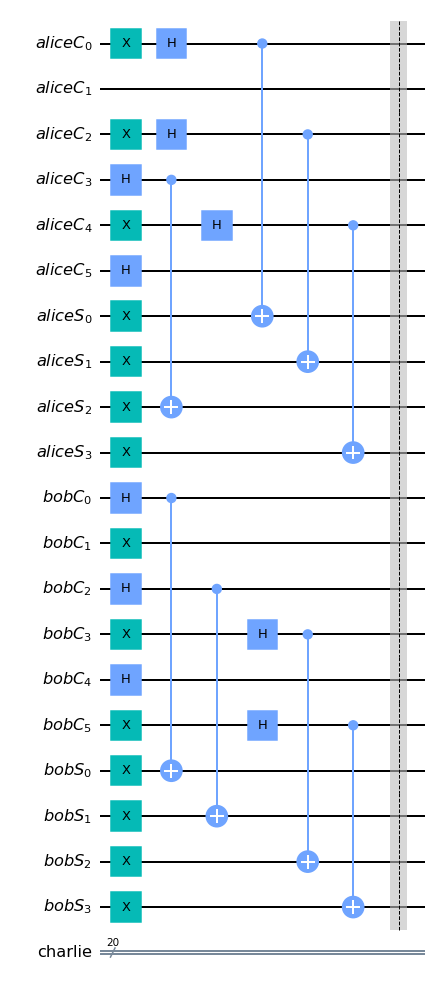

In [4]:
circuit = QuantumCircuit(Ca, Sa, Cb, Sb, Meas)

for i in range(num_epr):
    if a_epr_base[i] == 0:
        encode_psi_plus(circuit, Ca[Ca_epr[i]], Sa[i])
    elif a_epr_base[i] == 1:
        encode_psi_minus(circuit, Ca[Ca_epr[i]], Sa[i])
    if b_epr_base[i] == 0:
        encode_psi_plus(circuit, Cb[Cb_epr[i]], Sb[i])
    elif b_epr_base[i] == 1:
        encode_psi_minus(circuit, Cb[Cb_epr[i]], Sb[i])
        
for i in range(num_single):
    if a_single_qbit[i] == 1:
        circuit.x(Ca[Ca_single[i]])
    if a_single_base[i] == 1:
        circuit.h(Ca[Ca_single[i]])
    if b_single_qbit[i] == 1:
        circuit.x(Cb[Cb_single[i]])
    if b_single_base[i] == 1:
        circuit.h(Cb[Cb_single[i]])
        
circuit.barrier()
circuit.draw(output = 'mpl')

#### Step 3 : Bell State Measurement

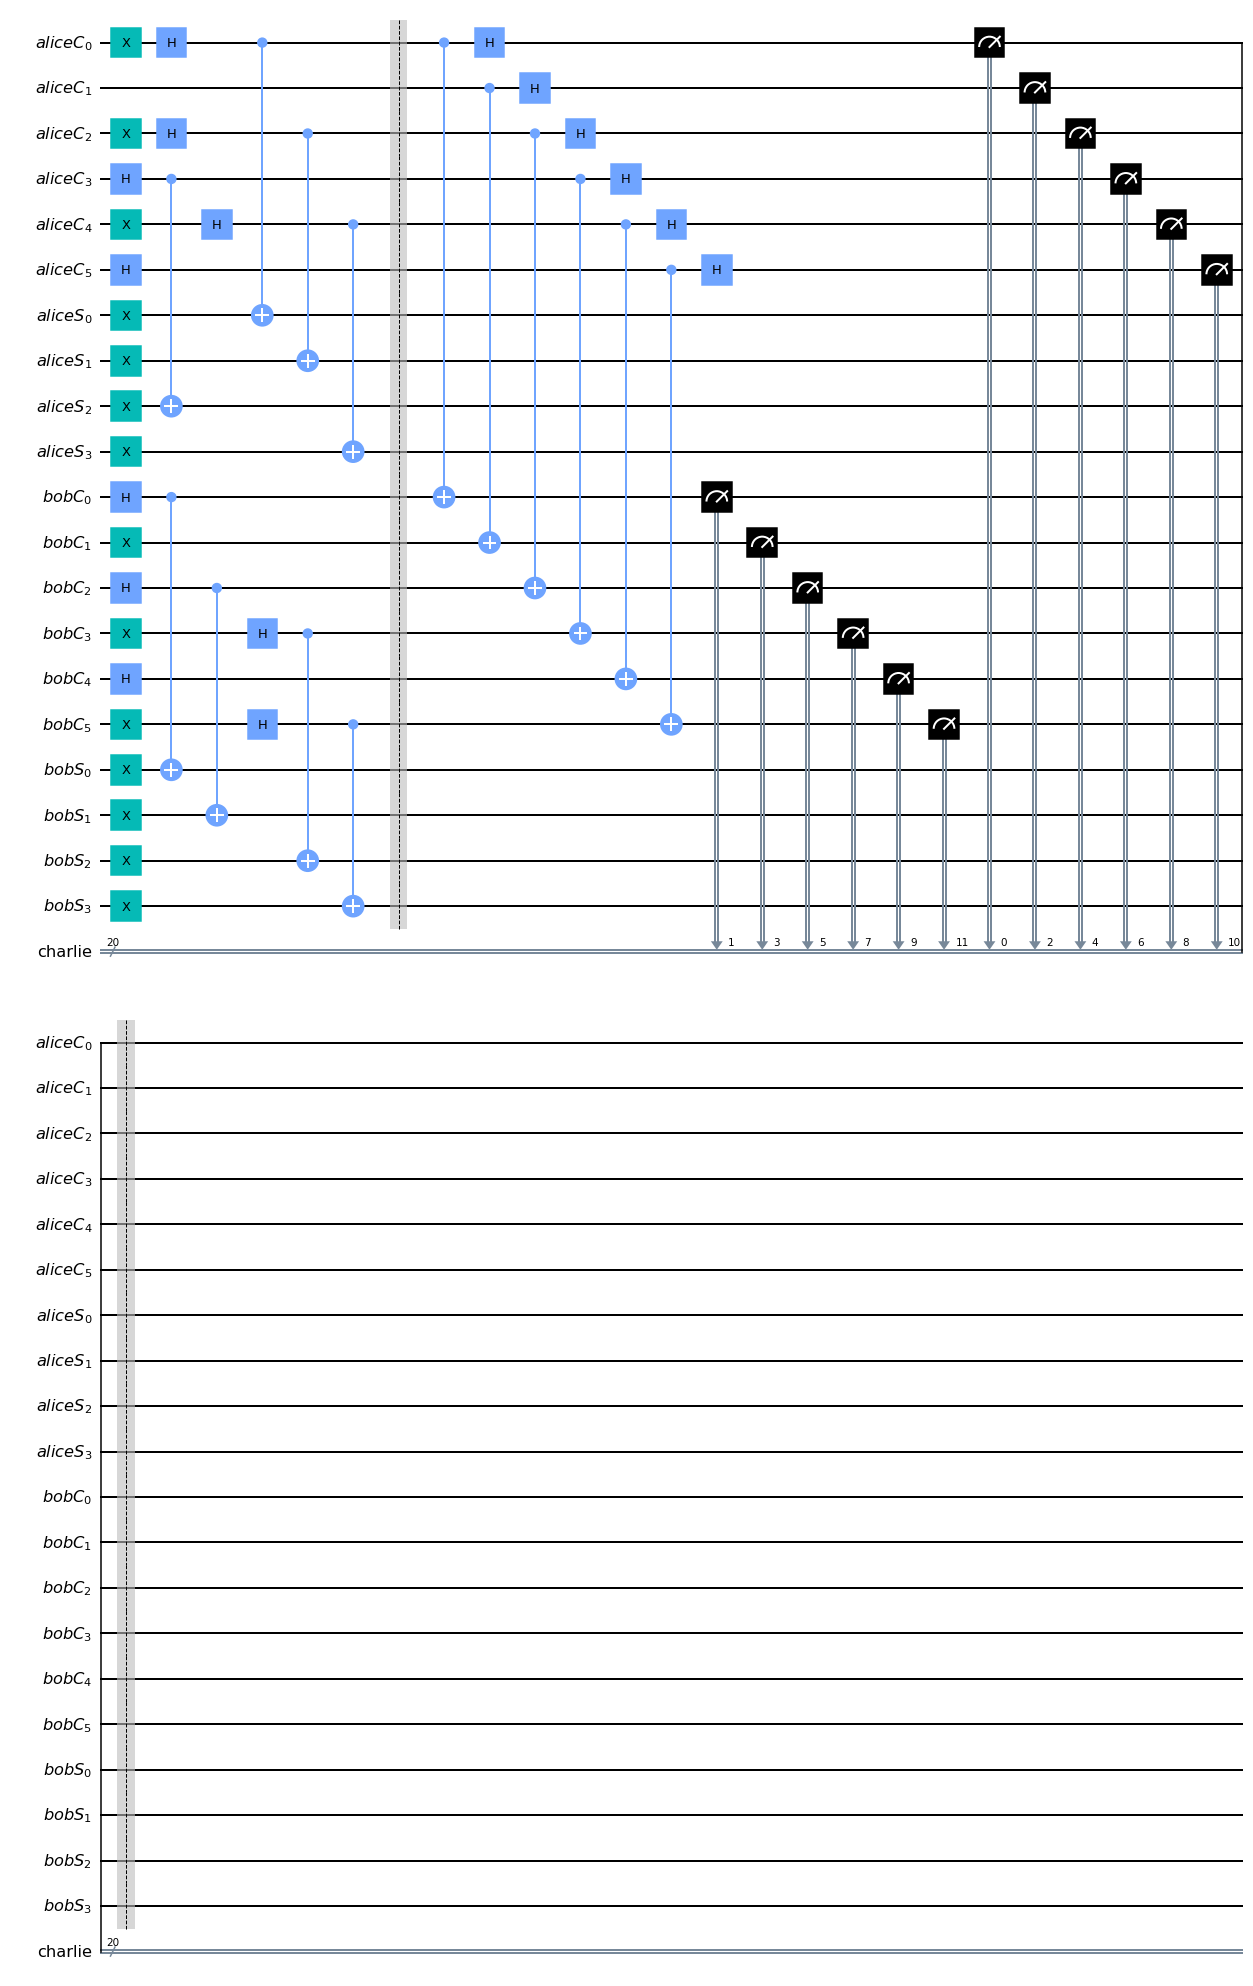

In [5]:
for i in range(num_epr + num_single):
    bell_meas(circuit, Ca[i], Cb[i])

for i in range(0, 2*(num_epr + num_single), 2):
    circuit.measure([Ca[i//2], Cb[i//2]], [i, i+1])

circuit.barrier()
circuit.draw(output = 'mpl')

#### Step 4: Security Checking
<br>
Now as we have hardcoded the EPR bits we know from which to check the Security and which qubits are to be discarded 
<br>
This can be generalised in more qubit range but will get difficult to implement as number of discarding qubits and security qubits will change which will sometimes for our case may lead to 0 security bits.
<br>
1. Here 2nd bit of Ca and 2nd bit of Cb will be checked for security
<br>
2. 5th and 6th bit of Ca and Cb will be discarded as because of condition 
<br>
(all one indexed)
<br>
Here as we know security of a bit will not be checked if the bases of correspoding single bits are different 
<br>
If the bases of the corresponding bit are same then the result due to bell basis measuremnt could be as follows

![title](Images/img4.png)

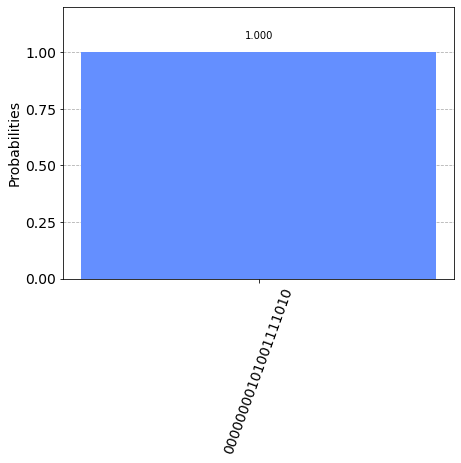

In [6]:
count1 = run_circuit(circuit, 1)
plot_histogram(count1)

In [7]:
result1 = count_to_str(count1)
result1 = result1[::-1]
bit1 = result1[2]
bit2 = result1[3]
flag = -1 
# For security checking

if a_single_base[0] == b_single_base[0]:
    flag = 0
    if bit1 == "0" and bit2 == "0":
        if a_single_qbit == b_single_qbit:
            flag = 1
    elif bit1 == "0" and bit2 == "1":
        if a_single_base[0] == 0 and a_single_qbit != b_single_qbit:
            flag = 1
        elif a_single_base[0] == 1 and a_single_qbit == b_single_qbit:
            flag = 1
    elif bit1 == "1" and bit2 == "0":
        if a_single_base[0] == 1 and a_single_qbit != b_single_qbit:
            flag = 1
        elif a_single_base[0] == 0 and a_single_qbit == b_single_qbit:
            flag = 1
    else:
        if a_single_qbit != b_single_qbit:
            flag = 1
            
if flag == -1:
    print("Security Checking Not Done due to Basis Difference")
elif flag == 0:
    print("Security Checking Failed")
else:
    print("Security Checking Passed")

Security Checking Passed


Here In above we have considered only the case shown in the diagram at starting

#### Step 5: Message Encoding
<br>
Now the qubits which are entangled due to entanglement swapping the Message encoding will be done 
<br>
This message encoding will be done according to the message as shown in the table
![title](Images/img2.png)
<br>
But first all the qubits of alice which were initialised with <b>Psi_Plus</b> will be converted to <b>Psi_Minus</b> by applying a <b>Sigma_Z</b> Gate to the Alice half qubits

Here A random message will be generated of lenght 2 times the number of entangled qubits 

In [8]:
all_discarded = np.unique(np.array([Ca_single, Cb_single]))
num_entangled = num_epr + num_single - len(all_discarded)
message = np.random.randint(2, size = 2*num_entangled)

Ca_Sa = {}
Cb_Sb = {}
for i in range((num_epr)):
    Ca_Sa[Ca_epr[i]] = i
    Cb_Sb[Cb_epr[i]] = i
    
    
print("The Initial Message is : " + str(message))

The Initial Message is : [1 0 1 1 1 0]


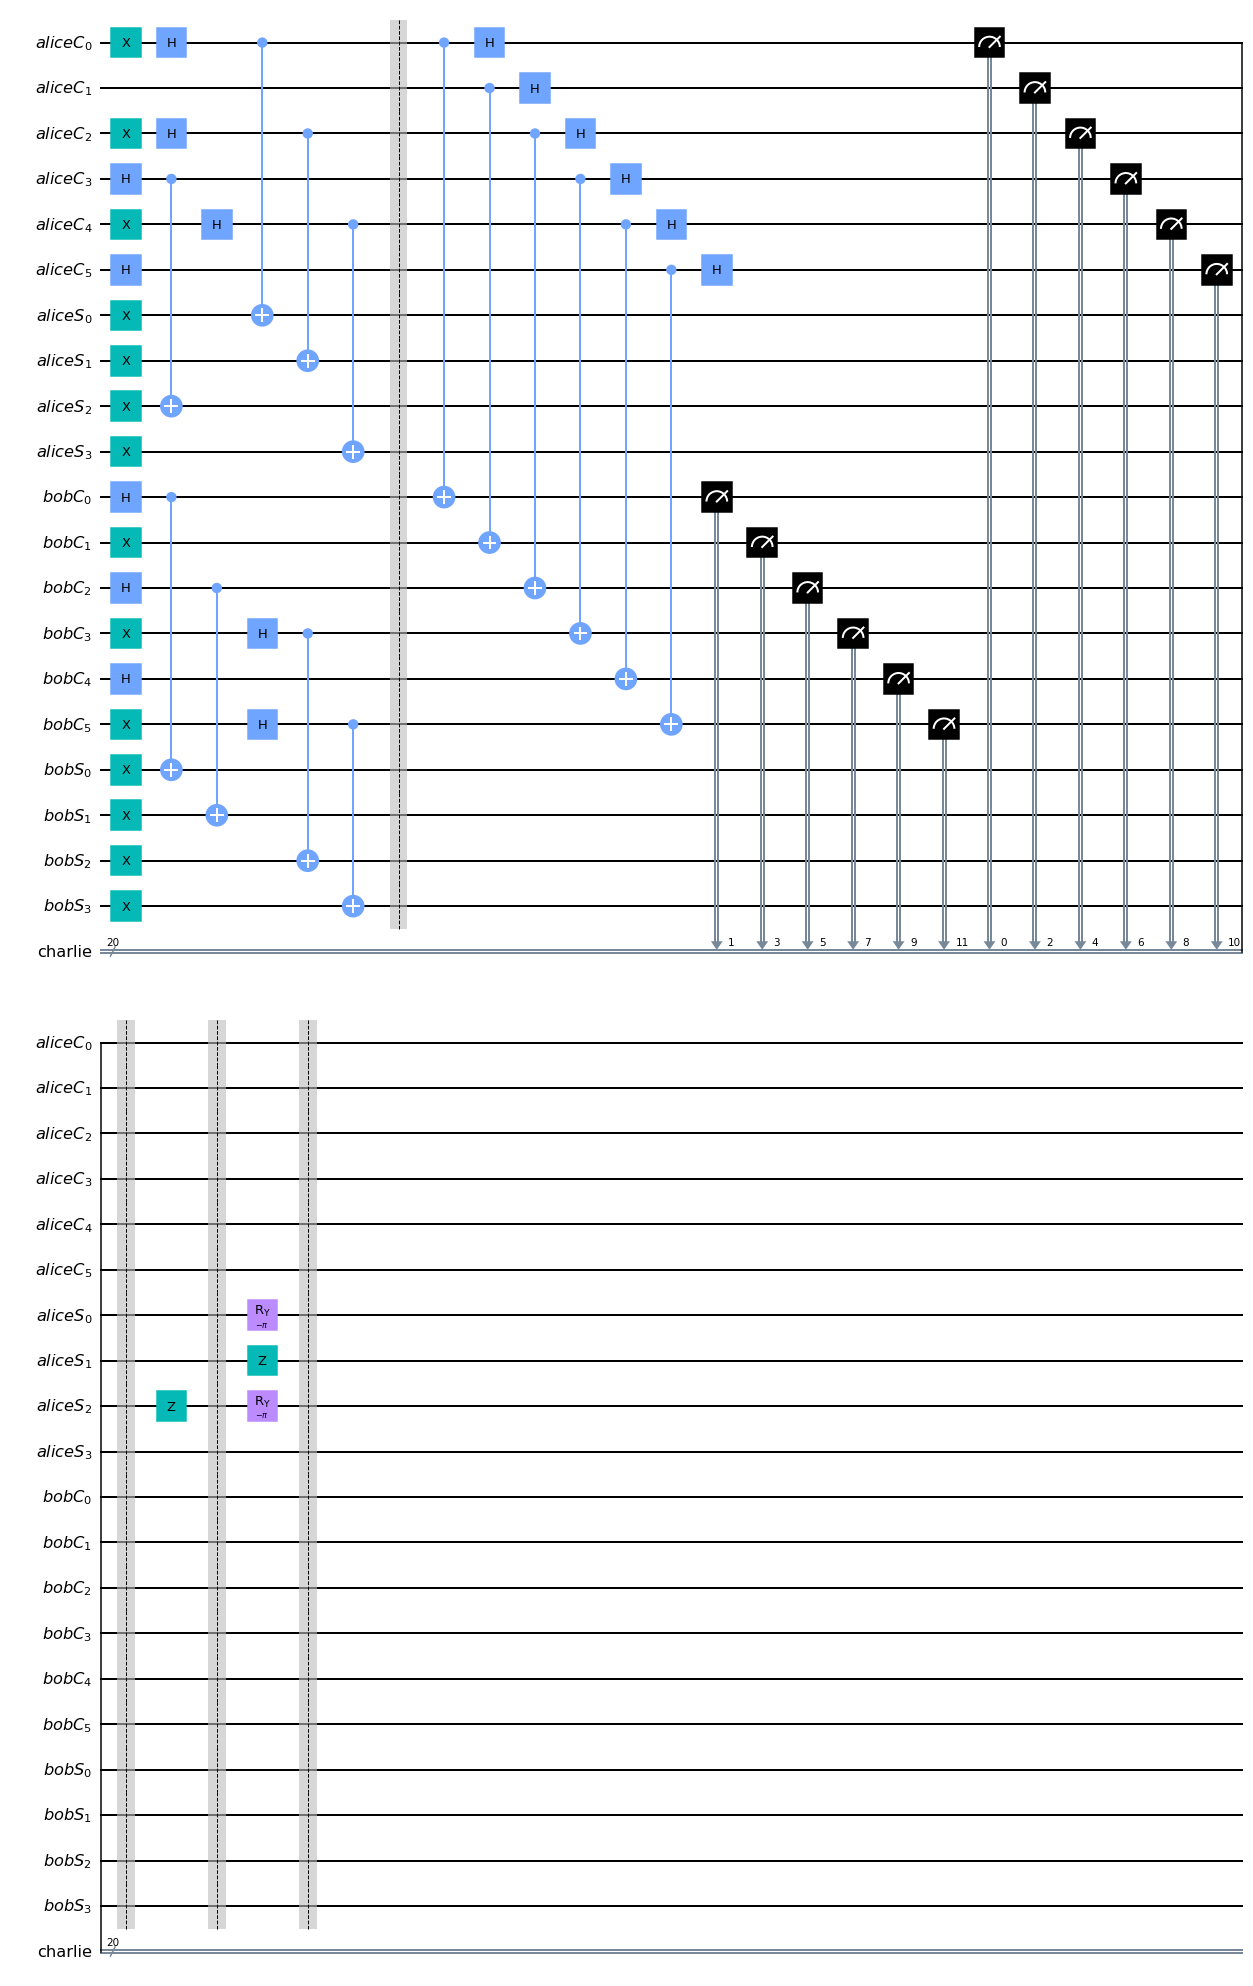

In [9]:
#Conversion of Alice Psi_Plus qubits into Psi_minus
S_useful = []

for i in range(num_epr):
    idx = Ca_epr[i] 
    if idx not in all_discarded:
        val = Ca_Sa[idx]
        if a_epr_base[i] == 0:
            circuit.z(Sa[val])
        S_useful.append(val)
        
circuit.barrier()

#Message Encoding 
for i in range((num_entangled)):
    k = 2*i
    val = S_useful[i]
    if message[k] == 0 and message[k+1] == 1:
        circuit.x(Sa[val])
    elif message[k] == 1 and message[k+1] == 0:
        circuit.ry(-np.pi, Sa[val])
    elif message[k] == 1 and message[k+1] == 1:
        circuit.z(Sa[val])

circuit.barrier()
circuit.draw(output = 'mpl')

#### Step 6: Decoding Step
<br>
1. Now first the bell basis measurement will be done by a Third Party Charlie of Sa and Sb and the results will be announced
<br>
2. Using these results bob will now decode his message

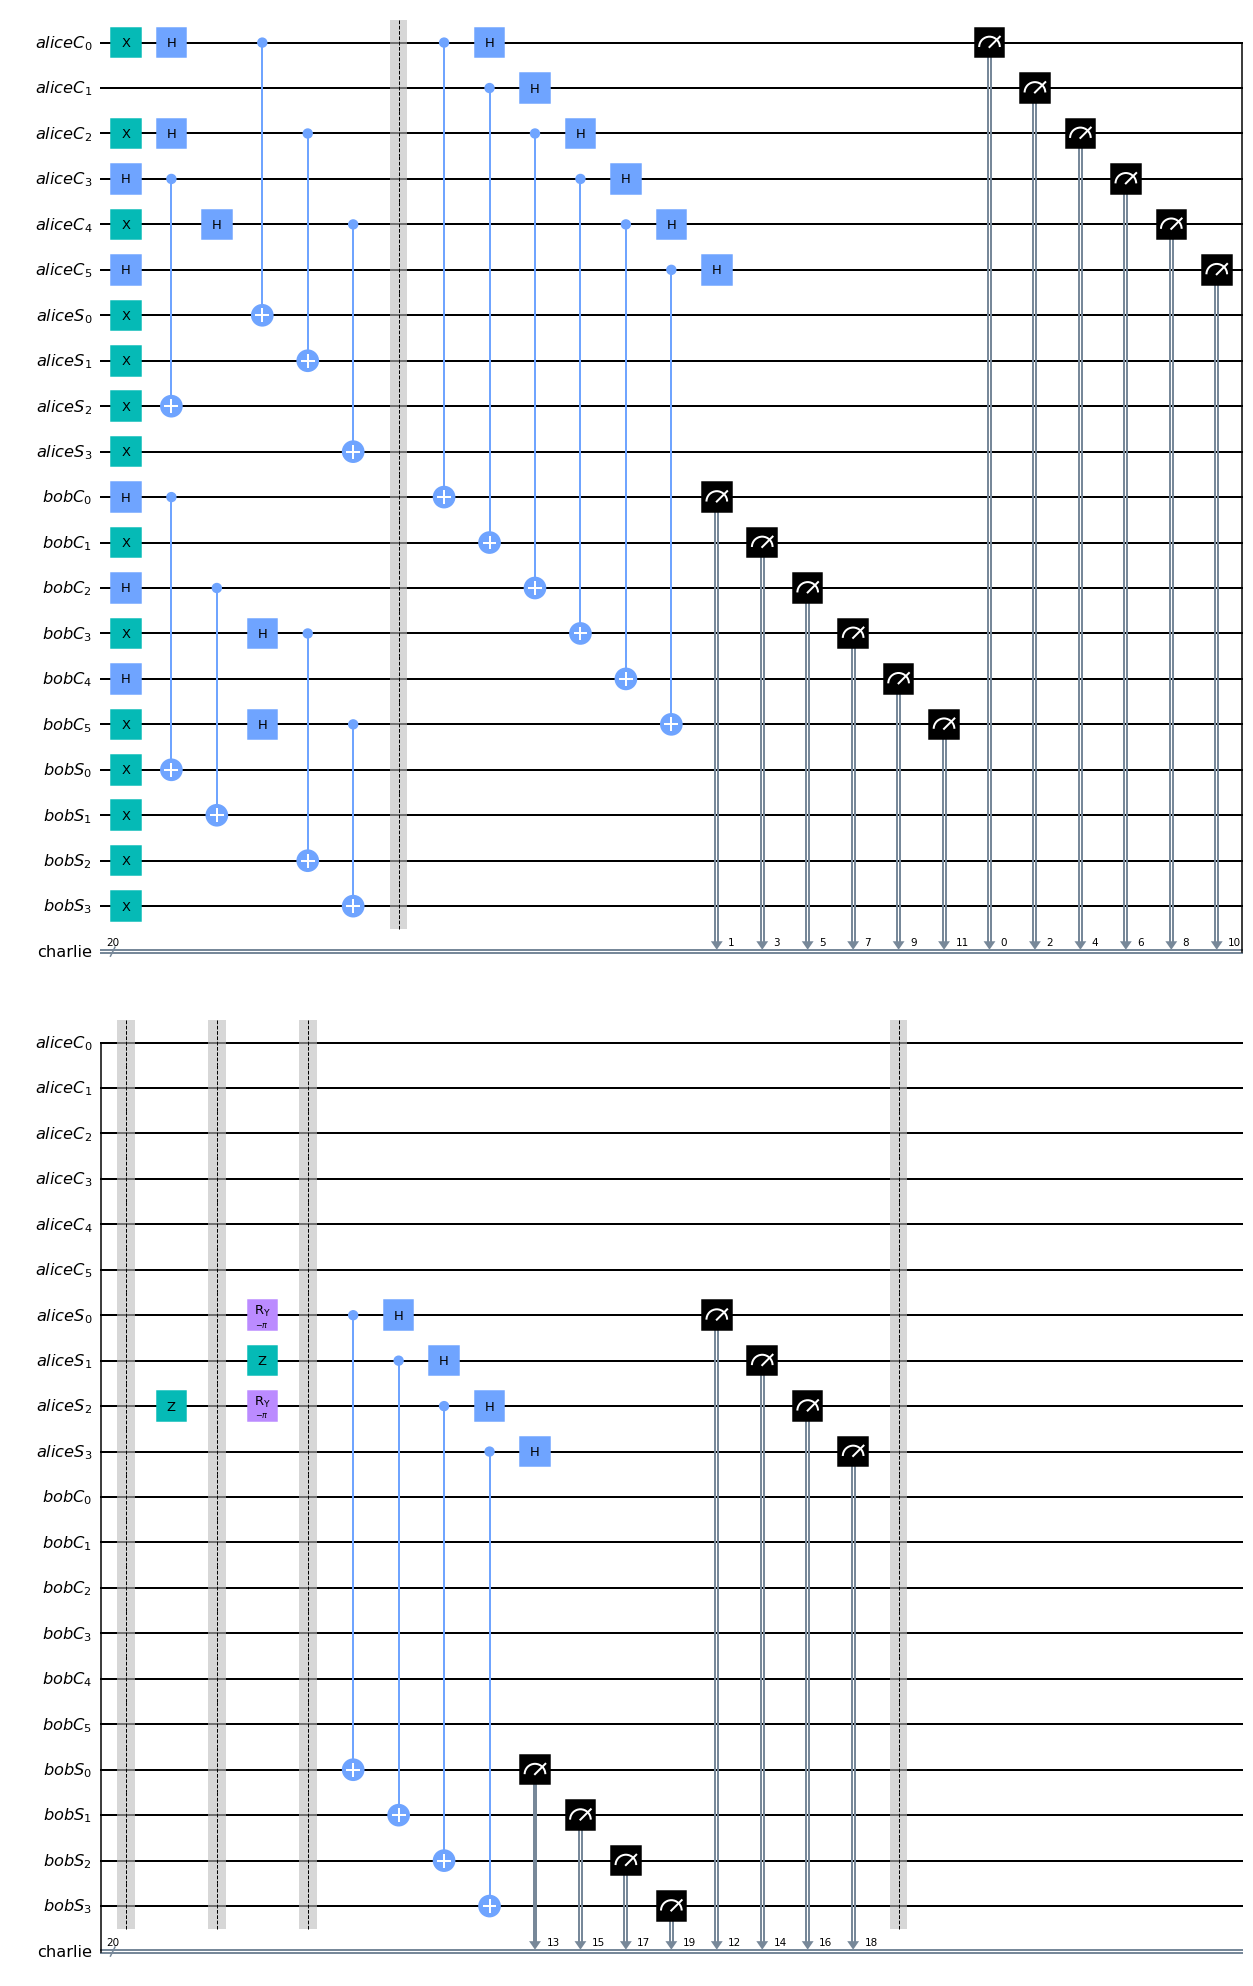

In [10]:
j = 2*num_single + 2*num_epr
for i in range(num_epr):
    circuit.cx(Sa[i], Sb[i])
    circuit.h(Sa[i])
    circuit.measure([Sa[i], Sb[i]], [j, j+1])
    j = j+2
circuit.barrier()
circuit.draw(output = 'mpl')

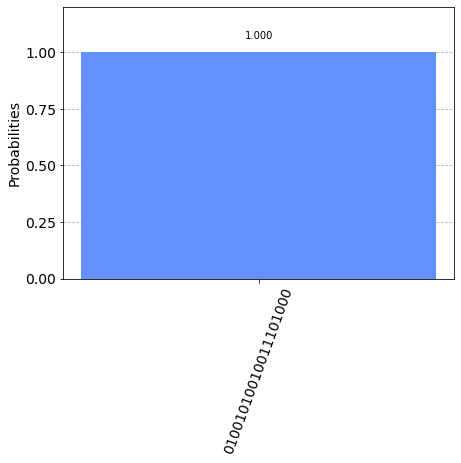

In [11]:
final_count = run_circuit(circuit, 1)
plot_histogram(final_count)

In [12]:
final_result = count_to_str(final_count)
final_result = final_result[::-1]
second_result = final_result[2*num_epr + 2*num_single:]
first_result = final_result[:2*num_epr + 2*num_single]

final_second_result = []
final_first_result = []

for i in range(num_epr + num_single):
    if i not in all_discarded:
        final_first_result.append(first_result[2*i])
        final_first_result.append(first_result[2*i + 1])

for i in range(num_epr):
    if i in S_useful:
        final_second_result.append(second_result[2*i])
        final_second_result.append(second_result[2*i + 1])

Here we have considered the case of single qubits and we have discarded qubit accordingly in the above cell

Now to decode the message we look at the following picture
![title](Images/img1.png)

Now Bob knows the Bases of Alice as they are all Psi_Minus 
so Bob just need to compare the
first Result and second result calculate in upper cell
<br>
Now we just need to compare these result with the table given in the 
research paper pdf

In [13]:
decoded = []

for i in range(0, 2*num_entangled, 2):
    idx = S_useful[i//2]
    bob_base = b_epr_base[idx]
    f = final_first_result[i:i+2]
    s = final_second_result[i:i+2]
    bp = 0 
    pp = 0 
    if f[0] != s[0]:
        bp = 1
    if f[1] != s[1]:
        pp = 1
    if bob_base == 0:
        bp = 1 - bp

    if bp == 0 and pp == 0:
        decoded.append(0)
        decoded.append(0)
    elif bp == 0 and pp == 1:
        decoded.append(0)
        decoded.append(1)
    elif bp == 1 and pp == 0:
        decoded.append(1)
        decoded.append(1)
    else:
        decoded.append(1)
        decoded.append(0)
        
decoded = np.array(decoded)
print(decoded)
print(message)

comparison = decoded == message
equal_arrays = comparison.all()

if equal_arrays == True:
    print("The code ran successfully")
else:
    print("Wrong Decoded Message")

[1 0 1 1 1 0]
[1 0 1 1 1 0]
The code ran successfully
